<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Перечень-функций" data-toc-modified-id="Перечень-функций-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Перечень функций</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Подготовка-модели" data-toc-modified-id="Подготовка-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка модели</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Анализ-метрики-auc_roc-алгоритма-LogisticRegression" data-toc-modified-id="Анализ-метрики-auc_roc-алгоритма-LogisticRegression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Анализ метрики auc_roc алгоритма LogisticRegression</a></span></li><li><span><a href="#Анализ-метрики-auc_roc-алгоритма-RandomForestClassifier" data-toc-modified-id="Анализ-метрики-auc_roc-алгоритма-RandomForestClassifier-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Анализ метрики auc_roc алгоритма RandomForestClassifier</a></span></li><li><span><a href="#Анализ-метрики-auc_roc-алгоритма-XGBClassifier" data-toc-modified-id="Анализ-метрики-auc_roc-алгоритма-XGBClassifier-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Анализ метрики auc_roc алгоритма XGBClassifier</a></span></li><li><span><a href="#Анализ-метрики-auc_roc-алгоритма-LGBMClassifier" data-toc-modified-id="Анализ-метрики-auc_roc-алгоритма-LGBMClassifier-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Анализ метрики auc_roc алгоритма LGBMClassifier</a></span></li></ul></li><li><span><a href="#Итого" data-toc-modified-id="Итого-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итого</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import scorer 

from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import cross_validate as cval
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.utils import shuffle

import warnings
import logging

C:\Users\George\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
warnings.filterwarnings='ignore'
logging.getLogger().setLevel(logging.CRITICAL) 
pd.options.mode.chained_assignment = None
rs = 0

## Перечень функций

In [3]:
def missing_values(df):
    data = pd.DataFrame(columns=['NaN_part', 'empty_counts', 'space_counts', '0_counts', 'unique_counts',\
                                          'min_value', 'max_value', 'dupl_sum', 'dtypes', 'length'], index=df.columns)
    for column in df.columns:
        data['NaN_part'][column] = df[column].isnull().mean()
        data['empty_counts'][column] = df[df[column] == ''][column].count()
        data['space_counts'][column] = df[df[column] == ' '][column].count()
        data['0_counts'][column] = df[df[column] == 0][column].count()
        data['unique_counts'][column] = len(df[column].unique())
        data['min_value'][column] = df[column].min()
        data['max_value'][column] = df[column].max()
        data['dupl_sum'][column] = df[column].duplicated().sum()
        data['dtypes'][column] = df[column].dtypes
        data['length'][column] = len(df[column])
    return data        

In [4]:
def missing_value(df):
    data = pd.DataFrame(columns=['NaN_part', 'empty_counts', 'space_counts', '0_counts', 'unique_counts',\
                                          'dupl_sum', 'dtypes', 'length'], index=df.columns)
    for column in df.columns:
        data['NaN_part'][column] = df[column].isnull().mean()
        data['empty_counts'][column] = df[df[column] == ''][column].count()
        data['space_counts'][column] = df[df[column] == ' '][column].count()
        data['0_counts'][column] = df[df[column] == 0][column].count()
        data['unique_counts'][column] = len(df[column].unique())
        data['dupl_sum'][column] = df[column].duplicated().sum()
        data['dtypes'][column] = df[column].dtypes
        data['length'][column] = len(df[column])
    return data        

In [5]:
def cv_search(model, features_train, target_train, features_test):
    n_scores = pd.DataFrame(cval(model, features_train, target_train, scoring=('f1'), return_train_score=True))
    train = n_scores.train_score.mean()
    valid = n_scores.test_score.mean()
    
    model.fit(features_train, target_train)
    prob = model.predict_proba(features_test)
    prob_test_ones = prob[:, 1]
    predict_test = prob_test_ones > 0.5
    test = f1_score(target_test, predict_test)

    print('Перекресная проверка (кросс-валидация):')
    print(f'f1 на обучающей выборке: {train}')
    print(f'f1 на валидационной выборке: {valid}')
    print(f'f1 на тестовой выборке: {test}')
    print()
    print(f'Разница метрики f1 между train and valid не превышает {(train - valid) * 100 / train:.2}%. Переобучения нет, если разница <10%')
    print(f'Разница метрики f1 между train and test не превышает {(train - test) * 100 / train:.2}%.')

    predict_test = model.predict(features_test)
    print()
    print('Тестовая выборка:')
    print('Доля положительных предсказаний от всех правильных предсказаний - Recall: ', recall_score(target_test, predict_test))
    print('Доля положительных предсказаний от всех положительных предсказаний - Precision: ', precision_score(target_test, predict_test))
    print('Среднее гармоническое полноты и точности - F1:', f1_score(target_test, predict_test))
    print('Accuracy:', accuracy_score(target_test, predict_test))
    print('ROC_AUC = ', roc_auc_score(target_test, predict_test))

In [6]:
def upsample(features, target, repeat_zeros=1, repeat_ones=1):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] * repeat_zeros + [features_ones] * repeat_ones)
    target_upsampled = pd.concat([target_zeros] * repeat_zeros + [target_ones] * repeat_ones)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=rs)
    
    return features_upsampled, target_upsampled

In [7]:
def downsample(features, target, fraction_zeros=1, fraction_ones=1):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction_zeros, random_state=rs)] + 
                                     [features_ones.sample(frac=fraction_ones, random_state=rs)])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction_zeros, random_state=rs)] + 
                                   [target_ones.sample(frac=fraction_ones, random_state=rs)])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=rs)
    
    return features_downsampled, target_downsampled

In [8]:
def threshold(begin, end, step, features, target, prob_ones):   
    best_f1 = 0
    best_threshold = -1
    best_auc = -1
    best_accuracy = 0
    for threshold in np.arange(begin, end, step):
        predict = prob_ones > threshold
        
        precision = precision_score(target, predict)
        recall = recall_score(target, predict)
        f1 = f1_score(target, predict)        
        auc = roc_auc_score(target, prob_ones)
        accuracy = accuracy_score(target, predict)
                
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_auc = auc
            best_accuracy = accuracy
                    
    return(best_f1, best_accuracy, best_auc, best_threshold)

In [9]:
def auc_roc_plot(model, target, predict):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6), facecolor='gray')
    fig.suptitle('Зависимость метрик от изменения порога')

    precision, recall, threshold = precision_recall_curve(target, predict)
    dictionary = {'precision':pd.Series(precision), 'recall':pd.Series(recall)}
    pr = pd.DataFrame(dictionary)

    fpr, tpr, thresholds = roc_curve(target, predict)
    dictionar = {'fpr':pd.Series(fpr), 'tpr':pd.Series(tpr)}
    ftpr = pd.DataFrame(dictionar)
    
    ax1.step(recall, precision)
    ax1.grid(True)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Кривая Precision-Recall')

    ax2.step(fpr, tpr, where='post')
    ax2.grid(True)
    ax2.plot([0,1], [0,1], linestyle='--')
    ax2.set_xlabel('false positive rate')
    ax2.set_ylabel('true positive rate')
    ax2.set_title('ROC-кривая')

In [10]:
def predict_plot(target, predict, count): #найти точечный график
    plt.figure(figsize=(16,8), facecolor='gray')
    plt.plot(target.values[:count], label='actual')
    plt.plot(predict[:count], label='predictions')
    plt.legend(loc='best')
    plt.grid()

## Анализ данных

Рассмотрю таблицу contract

In [11]:
try:
    contract = pd.read_csv('datasets/final_provider/contract.csv', index_col=[0])
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col=[0])
contract.sample(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4616-EWBNJ,2018-10-01,No,One year,No,Bank transfer (automatic),20.10,318.6
2159-TURXX,2019-09-01,No,Month-to-month,No,Credit card (automatic),20.05,95.55
3537-RYBHH,2016-03-01,No,Month-to-month,Yes,Credit card (automatic),67.45,3252
3936-QQFLL,2019-12-01,No,Month-to-month,No,Mailed check,19.75,39.3
6834-NXDCA,2018-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,23.90,300.8
9488-FYQAU,2014-11-01,No,Two year,Yes,Bank transfer (automatic),109.25,6841.4
6543-XRMYR,2017-07-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,99.70,2967.35
9057-MSWCO,2017-10-01,2020-01-01 00:00:00,Month-to-month,No,Credit card (automatic),30.75,805.1
8705-WZCYL,2020-01-01,No,Month-to-month,Yes,Electronic check,44.80,44.8


In [12]:
missing_contract = missing_values(contract)
missing_contract

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
BeginDate,0,0,0,0,77,2013-10-01,2020-02-01,6966,object,7043
EndDate,0,0,0,0,5,2019-10-01 00:00:00,No,7038,object,7043
Type,0,0,0,0,3,Month-to-month,Two year,7040,object,7043
PaperlessBilling,0,0,0,0,2,No,Yes,7041,object,7043
PaymentMethod,0,0,0,0,4,Bank transfer (automatic),Mailed check,7039,object,7043
MonthlyCharges,0,0,0,0,1585,18.25,118.75,5458,float64,7043
TotalCharges,0,0,11,0,6531,,999.9,512,object,7043


In [13]:
contract['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Анализ таблицы contract приводит к следующим выводам:
- есть пропуски в признаке TotalCharges
- ряд признаков не соответствуют своему типу: BeginDate, EndDate, TotalCharges
- признак BeginDate необходимо привести к объекту date. Строчные данные надо перевести в дату. Скорее всего это должна быть конечная дата 01.02.2020
- отток клиентов начался 4 месяца назад
- в базе данных дана информация за 7 лет
- бд имеет 7044 наблюдений и 8 признаков

In [14]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 440.2+ KB


In [15]:
missing_contract = missing_values(contract)
missing_contract

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
BeginDate,0,0,0,0,77,2013-10-01 00:00:00,2020-02-01 00:00:00,6966,datetime64[ns],7043
EndDate,0,0,0,0,5,2019-10-01 00:00:00,No,7038,object,7043
Type,0,0,0,0,3,Month-to-month,Two year,7040,object,7043
PaperlessBilling,0,0,0,0,2,No,Yes,7041,object,7043
PaymentMethod,0,0,0,0,4,Bank transfer (automatic),Mailed check,7039,object,7043
MonthlyCharges,0,0,0,0,1585,18.25,118.75,5458,float64,7043
TotalCharges,0.00156183,0,0,0,6531,18.8,8684.8,512,float64,7043


In [16]:
contract[contract['TotalCharges'] < 20].head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
3679-XASPY,2020-01-01,No,Month-to-month,No,Electronic check,19.45,19.45
3930-ZGWVE,2020-01-01,No,Month-to-month,No,Mailed check,19.75,19.75
1098-TDVUQ,2020-01-01,No,Month-to-month,Yes,Bank transfer (automatic),19.25,19.25
7302-ZHMHP,2020-01-01,No,Month-to-month,No,Mailed check,19.15,19.15
4800-VHZKI,2019-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Mailed check,19.90,19.90


In [17]:
contract[contract['MonthlyCharges'] == contract['TotalCharges']]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
8779-QRDMV,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,39.65,39.65
1066-JKSGK,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,20.15,20.15
8665-UTDHZ,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Electronic check,30.20,30.20
7310-EGVHZ,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,20.20
...,...,...,...,...,...,...,...
5351-QESIO,2020-01-01,No,Month-to-month,No,Mailed check,24.20,24.20
0723-DRCLG,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,74.45,74.45
1471-GIQKQ,2020-01-01,No,Month-to-month,No,Electronic check,49.95,49.95


Анализ предобработанной таблицы показывает:
- пропуски в признаке EndDate указывают не только на вероятность того, что потребители пользуются услугами на 01.02.2020, но и то, что услугу покупали единожды и больше не пользовались. Часть данных в признаке EndDate имеет подтверждение - услуги были предоставлены на месяц, другая часть данных имеет пропуски. 
- 613 человек не пользовались услугами оператора больше месяца. У половины из них дата окончания пользования услугами неопределена.
- 73% данных признака EndDate отсутствуют. Слишком много, удалять нельзя - необходимо обрабатывать.
- 0.15% данных признака TotalCharges отсутствуют. Это мало, можно удалить данные.

Рассмотрю таблицу internet

In [18]:
try:
    internet = pd.read_csv('datasets/final_provider/internet.csv', index_col=[0])
except:
    internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col=[0])
internet.sample(10)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
4626-OZDTJ,DSL,No,Yes,No,Yes,Yes,Yes
3716-LRGXK,Fiber optic,No,No,Yes,No,Yes,Yes
9728-FTTVZ,Fiber optic,No,No,No,No,No,No
3923-CSIHK,Fiber optic,No,No,No,No,No,No
6319-IEJWJ,Fiber optic,No,No,No,No,Yes,Yes
8328-SKJNO,DSL,Yes,Yes,No,Yes,No,No
1010-DIAUQ,Fiber optic,No,No,Yes,No,Yes,Yes
3884-UEBXB,DSL,Yes,Yes,No,No,No,No
8221-EQDGL,DSL,Yes,Yes,Yes,No,No,No


In [19]:
missing_internet = missing_values(internet)
missing_internet

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
InternetService,0,0,0,0,2,DSL,Fiber optic,5515,object,5517
OnlineSecurity,0,0,0,0,2,No,Yes,5515,object,5517
OnlineBackup,0,0,0,0,2,No,Yes,5515,object,5517
DeviceProtection,0,0,0,0,2,No,Yes,5515,object,5517
TechSupport,0,0,0,0,2,No,Yes,5515,object,5517
StreamingTV,0,0,0,0,2,No,Yes,5515,object,5517
StreamingMovies,0,0,0,0,2,No,Yes,5515,object,5517


Анализ таблицы internet приводит к следующим выводам:
- данных в таблице internet меньше чем данных в таблице contract
- все признаки бинарны
- все признаки типа object
- в таблице 5517 наблюдений и 8 признаков

Рассмотрю таблицу personal

In [20]:
try:
    personal = pd.read_csv('datasets/final_provider/personal.csv', index_col=[0])
except:
    personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col=[0])
personal.sample(10)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
9848-JQJTX,Male,0,No,No
1036-GUDCL,Male,0,Yes,Yes
9430-NKQLY,Male,0,Yes,Yes
7694-VLBWQ,Male,0,Yes,No
4293-ETKAP,Female,0,Yes,Yes
4976-LNFVV,Male,1,Yes,No
7096-UCLNH,Male,0,No,No
0404-SWRVG,Male,0,No,No
4062-HBMOS,Male,0,No,No


In [21]:
missing_personal = missing_values(personal)
missing_personal

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
gender,0,0,0,0,2,Female,Male,7041,object,7043
SeniorCitizen,0,0,0,5901,2,0,1,7041,int64,7043
Partner,0,0,0,0,2,No,Yes,7041,object,7043
Dependents,0,0,0,0,2,No,Yes,7041,object,7043


Анализ данных в таблице peronal:
- все признаки бинарные, 1 типа integer, остильные типа object
- количество наблюдений соответствуют количеству наблюдений в таблице contract
- в таблице 7043 наблюдений и 5 признаков

Рассмотрю таблицу phone

In [22]:
try:
    phone = pd.read_csv('datasets/final_provider/phone.csv', index_col=[0])
except:
    phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col=[0])
phone.sample(10)

,MultipleLines
customerID,
7577-SWIFR,No
0269-XFESX,Yes
2931-VUVJN,Yes
5840-NVDCG,No
0708-SJDIS,Yes
5242-UOWHD,No
5647-URDKA,No
6000-UKLWI,No
8620-RJPZN,No


In [23]:
missing_phone = missing_values(phone)
missing_phone

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
MultipleLines,0,0,0,0,2,No,Yes,6359,object,6361


Анализ данных в таблице phone:
- в таблице 6361 наблюдения и 2 признака
- количество признаков не соответствует количеству признаков из таблицы contract, personal and internet

В ходе анализа возникли следующие вопросы:
- MonthlyCharges * month_count <> TotalCharges. Почему не всегда выполняется равенство?
- что такое PaperlessBilling и ряд других признаков?
- почему признак TotalCharges имеет пропуски?
- почему признак EndDate имеет строчный данные? Говорит ли строка 'No' о том, что абонет пользуется связью на 01.02.2020 год или не пользовался связью больше месяца?
- как обработать признак EndDate?
- почему количество наблюдений в таблицах разное?
- какой целевой признак - partner таблицы personal?

План решения задачи:
- обработать 73% данных признака EndDate и 0.15% данных признака TotalCharge
- разобраться в признаках всех таблиц и выделить те, которые необходимы будут для машинного обучения
- выбранные признаки объединить в 1 таблицу
- определиться с целевым признаком, скорее всего это признак Partner таблицы personal
- подготовить данные к машинному обучению: разбить на выборки, провести прямую кодировку и масштабирование данных
- проверка на дисбаланс классов
- проведение разных техник уменьшения влияния дисбаланса классов
- проведение машинного обучения с разными алгоритмами бустинга и бэггинга
- подбор параметров до значения метрики AUC-ROC >= 0.88

## Предобработка данных

In [24]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Добавлю новый признак - продолжительность пользования услугой и удалю признак BeginDate

In [25]:
contract['EndDate2'] = pd.to_datetime(contract['EndDate'].apply(lambda x: '2020-02-01' if x=='No' else x))
contract['ContractLive'] = contract['EndDate2'] - contract['BeginDate']
contract['ContractLive'] = contract['ContractLive'].dt.days
contract = contract.drop(columns=['BeginDate', 'EndDate2'])
contract.head()

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractLive
customerID,,,,,,,
7590-VHVEG,No,Month-to-month,Yes,Electronic check,29.85,29.85,31
5575-GNVDE,No,One year,No,Mailed check,56.95,1889.50,1036
3668-QPYBK,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,61
7795-CFOCW,No,One year,No,Bank transfer (automatic),42.30,1840.75,1371
9237-HQITU,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,61


Переведу целевой признак в бинарный вид типа integer

In [26]:
contract['EndDate'] = contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)
contract.head()

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractLive
customerID,,,,,,,
7590-VHVEG,0,Month-to-month,Yes,Electronic check,29.85,29.85,31
5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,1036
3668-QPYBK,1,Month-to-month,Yes,Mailed check,53.85,108.15,61
7795-CFOCW,0,One year,No,Bank transfer (automatic),42.30,1840.75,1371
9237-HQITU,1,Month-to-month,Yes,Electronic check,70.70,151.65,61


Удалю пропуски в признаки TotalCharges. Их происхождение мне неизвестно и как обрабатывать - непонятно.

In [27]:
contract = contract.dropna()
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EndDate           7032 non-null   int64  
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   ContractLive      7032 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 439.5+ KB


Объеденю все признаки в одну таблицу. 

In [28]:
df = contract.join([internet, personal, phone], how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EndDate           7032 non-null   float64
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   ContractLive      7032 non-null   float64
 7   InternetService   5512 non-null   object 
 8   OnlineSecurity    5512 non-null   object 
 9   OnlineBackup      5512 non-null   object 
 10  DeviceProtection  5512 non-null   object 
 11  TechSupport       5512 non-null   object 
 12  StreamingTV       5512 non-null   object 
 13  StreamingMovies   5512 non-null   object 
 14  gender            7032 non-null   object 
 15  SeniorCitizen     7032 non-null   int64  
 16  Partner           7032 non-null 

In [29]:
miss = missing_value(df)
miss

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,dupl_sum,dtypes,length
EndDate,0,0,0,5163,2,7030,float64,7032
Type,0,0,0,0,3,7029,object,7032
PaperlessBilling,0,0,0,0,2,7030,object,7032
PaymentMethod,0,0,0,0,4,7028,object,7032
MonthlyCharges,0,0,0,0,1584,5448,float64,7032
TotalCharges,0,0,0,0,6530,502,float64,7032
ContractLive,0,0,0,0,155,6877,float64,7032
InternetService,0.216155,0,0,0,3,7029,object,7032
OnlineSecurity,0.216155,0,0,0,3,7029,object,7032
OnlineBackup,0.216155,0,0,0,3,7029,object,7032


Заполню пропуски. Заменю их на No.

In [30]:
df = df.fillna('No')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EndDate           7032 non-null   float64
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   ContractLive      7032 non-null   float64
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  gender            7032 non-null   object 
 15  SeniorCitizen     7032 non-null   int64  
 16  Partner           7032 non-null 

In [31]:
miss = missing_values(df)
miss

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
EndDate,0,0,0,5163,2,0,1,7030,float64,7032
Type,0,0,0,0,3,Month-to-month,Two year,7029,object,7032
PaperlessBilling,0,0,0,0,2,No,Yes,7030,object,7032
PaymentMethod,0,0,0,0,4,Bank transfer (automatic),Mailed check,7028,object,7032
MonthlyCharges,0,0,0,0,1584,18.25,118.75,5448,float64,7032
TotalCharges,0,0,0,0,6530,18.8,8684.8,502,float64,7032
ContractLive,0,0,0,0,155,30,2191,6877,float64,7032
InternetService,0,0,0,0,3,DSL,No,7029,object,7032
OnlineSecurity,0,0,0,0,2,No,Yes,7030,object,7032
OnlineBackup,0,0,0,0,2,No,Yes,7030,object,7032


Переведу в числовое значение все возможные признаки. Таким образом я минимизирую количество категориальных признаков:

In [32]:
df = df.apply([lambda x: 1 if x=='No' else (0 if x=='Yes' else x)], axis=1).droplevel(level=1)
df.head()

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractLive,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
7590-VHVEG,0,Month-to-month,0,Electronic check,29.85,29.85,31,DSL,1,0,1,1,1,1,Female,0,0,1,1
5575-GNVDE,0,One year,1,Mailed check,56.95,1889.5,1036,DSL,0,1,0,1,1,1,Male,0,1,1,1
3668-QPYBK,1,Month-to-month,0,Mailed check,53.85,108.15,61,DSL,0,0,1,1,1,1,Male,0,1,1,1
7795-CFOCW,0,One year,1,Bank transfer (automatic),42.3,1840.75,1371,DSL,0,1,0,0,1,1,Male,0,1,1,1
9237-HQITU,1,Month-to-month,0,Electronic check,70.7,151.65,61,Fiber optic,1,1,1,1,1,1,Female,0,1,1,1


In [33]:
df.loc[df['InternetService'] == 1, 'InternetService'] = 'No'
df['gender'] = df['gender'].apply(lambda x: 1 if x=='Female' else 0)
df = df.apply(lambda x: x.astype(int) if x.name not in ['Type', 'PaymentMethod', 'InternetService', 'MonthlyCharges', 'TotalCharges'] else x)
df = df.apply(lambda x: x.astype(float) if x.name in ['MonthlyCharges', 'TotalCharges'] else x)
df.head()

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractLive,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
7590-VHVEG,0,Month-to-month,0,Electronic check,29.85,29.85,31,DSL,1,0,1,1,1,1,1,0,0,1,1
5575-GNVDE,0,One year,1,Mailed check,56.95,1889.50,1036,DSL,0,1,0,1,1,1,0,0,1,1,1
3668-QPYBK,1,Month-to-month,0,Mailed check,53.85,108.15,61,DSL,0,0,1,1,1,1,0,0,1,1,1
7795-CFOCW,0,One year,1,Bank transfer (automatic),42.30,1840.75,1371,DSL,0,1,0,0,1,1,0,0,1,1,1
9237-HQITU,1,Month-to-month,0,Electronic check,70.70,151.65,61,Fiber optic,1,1,1,1,1,1,1,0,1,1,1


In [34]:
miss = missing_values(df)
miss

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
EndDate,0,0,0,5163,2,0,1,7030,int32,7032
Type,0,0,0,0,3,Month-to-month,Two year,7029,object,7032
PaperlessBilling,0,0,0,4168,2,0,1,7030,int32,7032
PaymentMethod,0,0,0,0,4,Bank transfer (automatic),Mailed check,7028,object,7032
MonthlyCharges,0,0,0,0,1584,18.25,118.75,5448,float64,7032
TotalCharges,0,0,0,0,6530,18.8,8684.8,502,float64,7032
ContractLive,0,0,0,0,155,30,2191,6877,int32,7032
InternetService,0,0,0,0,3,DSL,No,7029,object,7032
OnlineSecurity,0,0,0,2015,2,0,1,7030,int32,7032
OnlineBackup,0,0,0,2425,2,0,1,7030,int32,7032


Предобработка выполнена

## Подготовка модели

Посмотрю на баланс классов

0    0.734215
1    0.265785
Name: EndDate, dtype: float64


<AxesSubplot:>

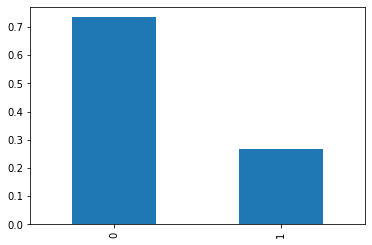

In [35]:
class_frequency = df['EndDate'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Есть дисбаланс классов. Стоит использовать техники по уменьшению влияния дисбаланса классов. Но сначала надо подготовить модель, удалить лишнее и подготовить к машинному обучению. 

Проведу кодирование и разобью датасет на общие и целевой признаки

In [36]:
features_ohe = pd.get_dummies(df, drop_first=True)
features_ohe.head()

,EndDate,PaperlessBilling,MonthlyCharges,TotalCharges,ContractLive,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Partner,Dependents,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
7590-VHVEG,0,0,29.85,29.85,31,1,0,1,1,1,...,0,1,1,0,0,0,1,0,0,0
5575-GNVDE,0,1,56.95,1889.50,1036,0,1,0,1,1,...,1,1,1,1,0,0,0,1,0,0
3668-QPYBK,1,0,53.85,108.15,61,0,0,1,1,1,...,1,1,1,0,0,0,0,1,0,0
7795-CFOCW,0,1,42.30,1840.75,1371,0,1,0,0,1,...,1,1,1,1,0,0,0,0,0,0
9237-HQITU,1,0,70.70,151.65,61,1,1,1,1,1,...,1,1,1,0,0,0,1,0,1,0


In [37]:
features = features_ohe.drop('EndDate', axis=1)
target = features_ohe['EndDate']
print(features.shape)
print(target.shape)

(7032, 22)
(7032,)


In [ ]:
features.reset_index(inplace=True, drop=True)
target = target.reset_index(drop=True)

Данные были закодированы и переведены в числовой вид. Теперь можно оценить мультиколлинеарность данных:

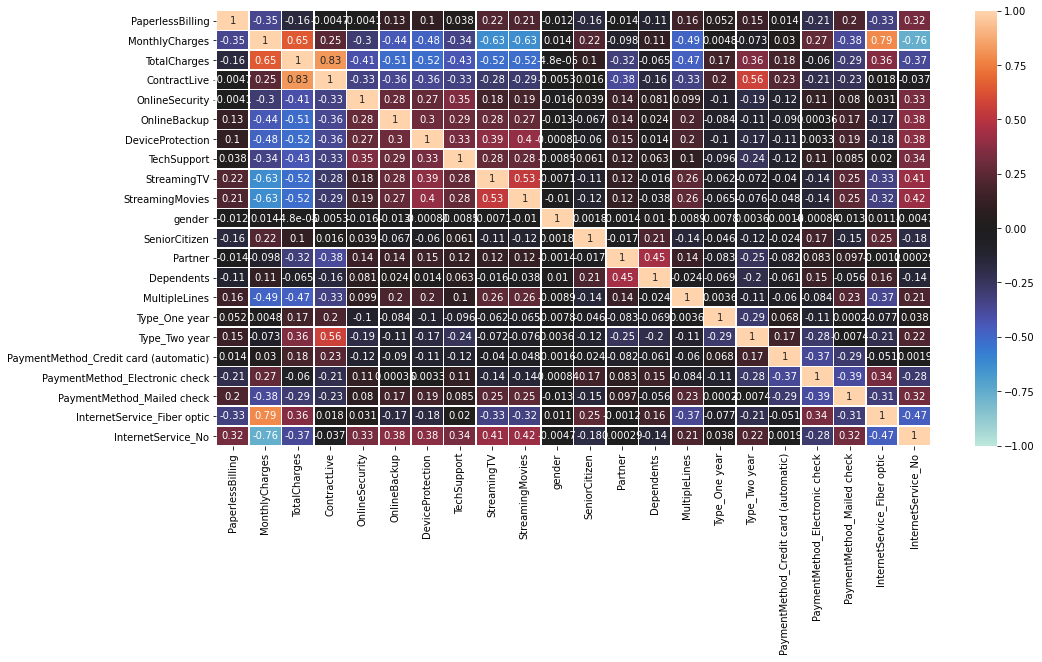

In [39]:
fig = plt.figure(figsize = (16,8))
sb.heatmap(features.corr(), vmin=-1, vmax=1, center=0, annot=True, linewidths=0.5)
plt.show();

Матрица корреляции признаков показывает, что есть:
- высокая положительная связь между MonthlyCharges and InternetService_Fiber optic (0.79), TotalCharges and ContractLive (0.83)
- высокая отрицательная связь между MonthlyCharges and InternetService_No
- относительно высокая положительная связь между MonthlyCarges and TotalCharges (0.65)
- относительно высокая отрицательная связь между MonthlyCharges and StreamingTV (0.63), MonthlyCharges and StreamingMovies (0.63)

Исходя из этих наблюдений, можно сделать вывод, что признак MonthlyCharges необходимо удалить, так как он участвует во всех высоких корреляционных связях.

Признаки TotalCharges and ContractLive также имеют высокую связь (0.83). Удаляю TotalCharges.

In [40]:
features = features.drop(columns=['MonthlyCharges', 'TotalCharges'])

In [41]:
features_train, features_test, target_train, target_test = train_test_split(features, target, train_size=0.75, 
                                                                            random_state=rs, stratify=target)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5274, 20)
(1758, 20)
(5274,)
(1758,)


In [42]:
features_train_val, features_valid, target_train_val, target_valid = train_test_split(features_train, target_train, train_size=0.7, 
                                                                                      random_state=rs, stratify=target_train)
print(features_train_val.shape)
print(features_valid.shape)
print(target_train_val.shape)
print(target_valid.shape)

(3691, 20)
(1583, 20)
(3691,)
(1583,)


In [43]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns, index=features_train.index)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns, index=features_test.index)
features_train_val = pd.DataFrame(scaler.transform(features_train_val), columns=features_train_val.columns, index=features_train_val.index)
features_valid = pd.DataFrame(scaler.transform(features_valid), columns=features_valid.columns, index=features_valid.index)

features_train.head()

,PaperlessBilling,ContractLive,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
1715,-0.815981,-1.240762,0.632204,-1.360445,0.727115,0.636907,-1.274828,0.802186,1.007613,2.222429,0.96827,0.648689,0.846969,-0.518366,-0.553548,-0.529829,-0.706805,-0.547700,1.124928,-0.520426
6648,1.225519,0.684006,0.632204,0.735054,0.727115,0.636907,0.784419,0.802186,1.007613,-0.449958,-1.03277,0.648689,0.846969,1.929139,-0.553548,-0.529829,-0.706805,-0.547700,-0.888945,1.921502
4949,-0.815981,-0.791200,0.632204,0.735054,0.727115,0.636907,0.784419,0.802186,-0.992444,-0.449958,0.96827,0.648689,0.846969,-0.518366,-0.553548,-0.529829,1.414817,-0.547700,-0.888945,1.921502
4673,-0.815981,-0.954065,0.632204,0.735054,0.727115,0.636907,0.784419,-1.246593,-0.992444,2.222429,0.96827,0.648689,-1.180681,-0.518366,-0.553548,-0.529829,1.414817,-0.547700,1.124928,-0.520426
3503,-0.815981,-1.282487,0.632204,0.735054,0.727115,0.636907,0.784419,0.802186,-0.992444,-0.449958,0.96827,0.648689,0.846969,-0.518366,-0.553548,-0.529829,-0.706805,1.825817,-0.888945,-0.520426


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>понял

In [44]:
model_dummy = DummyClassifier(random_state=rs, strategy='stratified')
cv_search(model_dummy, features_train, target_train, features_test)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.2603475692270264
f1 на валидационной выборке: 0.2565823964174623
f1 на тестовой выборке: 0.2565720294426919

Разница метрики f1 между train and valid не превышает 1.4%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 1.5%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.26124197002141325
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.25206611570247933
Среднее гармоническое полноты и точности - F1: 0.2565720294426919
Accuracy: 0.5978384527872582
ROC_AUC =  0.49041959074269736


Опорное значеник roc_auc = 0.49. Создам отдельные датасеты в которых приведу целевой класс к балансу по техникам увеличения и уменьшения классов:

In [45]:
features_downsampled, target_downsampled = downsample(features_train, target_train, fraction_zeros=0.3)

In [46]:
class_frequency = target_downsampled.value_counts(normalize=True)
print(class_frequency)

1    0.546802
0    0.453198
Name: EndDate, dtype: float64


In [47]:
features_upsampled, target_upsampled = upsample(features_train, target_train, repeat_ones=2)

In [48]:
class_frequency = target_upsampled.value_counts(normalize=True)
print(class_frequency)

0    0.579988
1    0.420012
Name: EndDate, dtype: float64


## Обучение модели

### Анализ метрики auc_roc алгоритма LogisticRegression

Проведу исследование и обучение модели LogisticRegression.

In [49]:
%%time
lr = LogisticRegression(random_state=rs, n_jobs=-1)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

gs_lr = GridSearchCV(lr, params, scoring=('f1'), n_jobs=-1, cv=5)
gs_lr.fit(features_train, target_train)
gs_lr.best_params_

Wall time: 7.34 s


C:\Users\George\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


{'solver': 'liblinear'}

In [50]:
model = LogisticRegression(**gs_lr.best_params_)
cv_search(model, features_train, target_train, features_test)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.5974990504621986
f1 на валидационной выборке: 0.5917798714193211
f1 на тестовой выборке: 0.5814234016887816

Разница метрики f1 между train and valid не превышает 0.96%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 2.7%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.5160599571734475
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.6657458563535912
Среднее гармоническое полноты и точности - F1: 0.5814234016887816
Accuracy: 0.8026166097838453
ROC_AUC =  0.7111670816076378


Попробую использовать атрибут баланса классов

In [51]:
%%time
lr = LogisticRegression(random_state=rs, n_jobs=-1, class_weight='balanced')
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

gs = GridSearchCV(lr, params, scoring=('f1'), n_jobs=-1, cv=5)
gs.fit(features_train, target_train)
gs.best_params_

Wall time: 645 ms


{'solver': 'newton-cg'}

In [52]:
model = LogisticRegression(**gs.best_params_)
cv_search(model, features_train, target_train, features_test)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.5974196805990581
f1 на валидационной выборке: 0.591373836231101
f1 на тестовой выборке: 0.5814234016887816

Разница метрики f1 между train and valid не превышает 1.0%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 2.7%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.5160599571734475
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.6657458563535912
Среднее гармоническое полноты и точности - F1: 0.5814234016887816
Accuracy: 0.8026166097838453
ROC_AUC =  0.7111670816076378


Техника добавления данных для баланса целевого класса

In [53]:
%%time
lr = LogisticRegression(random_state=rs, n_jobs=-1)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

gs = GridSearchCV(lr, params, scoring=('f1'), n_jobs=-1, cv=5)
gs.fit(features_upsampled, target_upsampled)
gs.best_params_

Wall time: 1.3 s


{'solver': 'newton-cg'}

In [54]:
model = LogisticRegression(**gs.best_params_)
cv_search(model, features_upsampled, target_upsampled, features_test)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.7267847974173189
f1 на валидационной выборке: 0.7227558968057394
f1 на тестовой выборке: 0.6263008514664145

Разница метрики f1 между train and valid не превышает 0.55%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 1.4e+01%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.708779443254818
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.5610169491525424
Среднее гармоническое полноты и точности - F1: 0.6263008514664145
Accuracy: 0.7753128555176336
ROC_AUC =  0.7540798842920101


Техника уменьшения данных для баланса целевого класса

In [55]:
%%time
lr = LogisticRegression(random_state=rs, n_jobs=-1)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

gs = GridSearchCV(lr, params, scoring=('f1'), n_jobs=-1, cv=5)
gs.fit(features_downsampled, target_downsampled)
gs.best_params_

Wall time: 428 ms


{'solver': 'newton-cg'}

In [56]:
model = LogisticRegression(**gs.best_params_)
cv_search(model, features_downsampled, target_downsampled, features_test)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.7925317942851023
f1 на валидационной выборке: 0.7863759189769735
f1 на тестовой выборке: 0.6185397867104184

Разница метрики f1 между train and valid не превышает 0.78%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 2.2e+01%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.8072805139186295
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.5013297872340425
Среднее гармоническое полноты и точности - F1: 0.6185397867104184
Accuracy: 0.735494880546075
ROC_AUC =  0.758404005991073


Техника изменения порога

In [57]:
model = LogisticRegression(**gs_lr.best_params_)
model.fit(features_train_val, target_train_val)
prob = model.predict_proba(features_valid)
prob_valid_ones = prob[:, 1]

f1, auc, accuracy, threshold_lr = threshold(begin=0, end=1, step=0.01, features=features_valid, 
                                              target=target_valid, prob_ones=prob_valid_ones)
print(f'Валидационная выборка на пороге threshold = {threshold_lr}:')
print(f'f1 = {f1}')
print(f'accuracy = {accuracy}')
print(f'auc = {auc}')

Валидационная выборка на пороге threshold = 0.53:
f1 = 0.58311345646438
accuracy = 0.8379503763271614
auc = 0.8003790271636134


C:\Users\George\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\George\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\George\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\George\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precis

In [58]:
best_model = LogisticRegression(**gs_lr.best_params_)
best_model.fit(features_train, target_train)
prob = best_model.predict_proba(features_test)
prob_test_ones = prob[:, 1]
predicted_test = prob_test_ones > threshold_lr

f1 = f1_score(target_test, predicted_test)
auc = roc_auc_score(target_test, predicted_test)
accuracy = accuracy_score(target_test, predicted_test)

print(f'Тестовая выборка на пороге threshold = {threshold_lr}:')
print(f'f1 = {f1}')
print(f'accuracy = {accuracy}')
print(f'auc = {auc}')

Тестовая выборка на пороге threshold = 0.53:
f1 = 0.5609137055837564
accuracy = 0.8031854379977247
auc = 0.6978870354305959


Наибольшее значение метрики auc_roc я получил при использовании техники уменьшения классов. auc_roc = 0.758

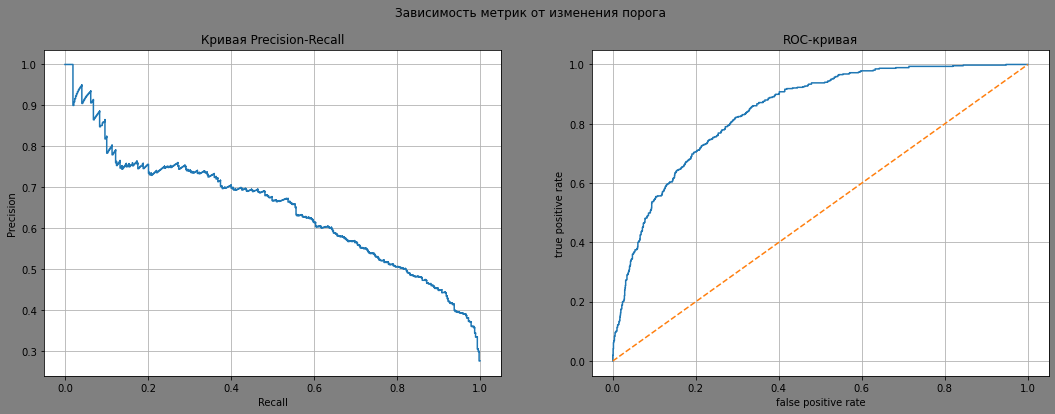

In [59]:
auc_roc_plot(best_model, target_test, prob_test_ones)

### Анализ метрики auc_roc алгоритма RandomForestClassifier

In [60]:
%%time
rfr = RandomForestClassifier(n_jobs=-1, random_state=rs)
params = {'n_estimators': [i for i in range(10, 300, 10)],
          'max_depth': [i for i in range(1, 6, 1)]}

gs_rfr = GridSearchCV(rfr, params, scoring=('f1'), n_jobs=-1, cv=3)
gs_rfr.fit(features_train, target_train)
gs_rfr.best_params_

Wall time: 1min 1s


{'max_depth': 5, 'n_estimators': 10}

In [61]:
model = RandomForestClassifier(**gs_rfr.best_params_)
cv_search(model, features_train, target_train, features_test)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.5407160699100757
f1 на валидационной выборке: 0.5385349108274872
f1 на тестовой выборке: 0.5435630689206762

Разница метрики f1 между train and valid не превышает 0.4%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает -0.53%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.4475374732334047
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.6920529801324503
Среднее гармоническое полноты и точности - F1: 0.5435630689206762
Accuracy: 0.8003412969283277
ROC_AUC =  0.6877501463765784


Посмотрю важность признаков и уменьшу признаковое пространство:

<AxesSubplot:>

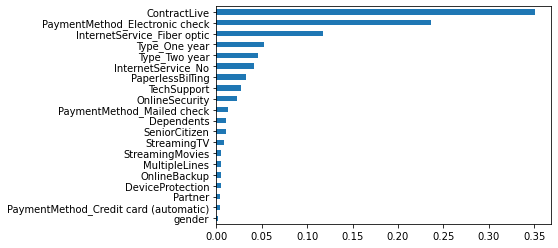

In [62]:
importances = pd.Series(model.feature_importances_, index=features.columns)
importances.sort_values().plot(kind='barh')

In [63]:
rfr_count = 6

In [64]:
features_train_forest = features_train.drop(columns=importances.sort_values(ascending=False).index[rfr_count:])
features_test_forest = features_test.drop(columns=importances.sort_values(ascending=False).index[rfr_count:])
features_train_forest.head()

,ContractLive,Type_One year,Type_Two year,PaymentMethod_Electronic check,InternetService_Fiber optic,InternetService_No
1715,-1.240762,-0.518366,-0.553548,-0.706805,1.124928,-0.520426
6648,0.684006,1.929139,-0.553548,-0.706805,-0.888945,1.921502
4949,-0.791200,-0.518366,-0.553548,1.414817,-0.888945,1.921502
4673,-0.954065,-0.518366,-0.553548,1.414817,1.124928,-0.520426
3503,-1.282487,-0.518366,-0.553548,-0.706805,-0.888945,-0.520426


In [65]:
%%time
rfr = RandomForestClassifier(n_jobs=-1, random_state=rs)
params = {'n_estimators': [i for i in range(10, 300, 10)],
          'max_depth': [i for i in range(1, 6, 1)]}

gs_rfr = GridSearchCV(rfr, params, scoring=('f1'), n_jobs=-1, cv=3)
gs_rfr.fit(features_train_forest, target_train)
gs_rfr.best_params_

Wall time: 58.9 s


{'max_depth': 5, 'n_estimators': 20}

In [66]:
model = RandomForestClassifier(**gs_rfr.best_params_)
cv_search(model, features_train_forest, target_train, features_test_forest)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.589450308819012
f1 на валидационной выборке: 0.5764288717556959
f1 на тестовой выборке: 0.5695876288659795

Разница метрики f1 между train and valid не превышает 2.2%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 3.4%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.4732334047109208
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.7152103559870551
Среднее гармоническое полноты и точности - F1: 0.5695876288659795
Accuracy: 0.8100113765642776
ROC_AUC =  0.7025345954615797


Использую технику изменения параметра леса class_weight='balanced':

In [67]:
%%time
rfr = RandomForestClassifier(n_jobs=-1, random_state=rs, class_weight='balanced')
params = {'n_estimators': [i for i in range(10, 300, 10)],
          'max_depth': [i for i in range(1, 6, 1)]}

gs = GridSearchCV(rfr, params, scoring=('f1'), n_jobs=-1, cv=3)
gs.fit(features_train_forest, target_train)
gs.best_params_

Wall time: 1min 6s


{'max_depth': 5, 'n_estimators': 180}

In [68]:
model = RandomForestClassifier(**gs.best_params_)
cv_search(model, features_train_forest, target_train, features_test_forest)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.5987954801288006
f1 на валидационной выборке: 0.5819931970968978
f1 на тестовой выборке: 0.5804816223067173

Разница метрики f1 между train and valid не превышает 2.8%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 3.1%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.49036402569593146
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.7111801242236024
Среднее гармоническое полноты и точности - F1: 0.5804816223067173
Accuracy: 0.8117178612059158
ROC_AUC =  0.7091634226078417


Использую техники уменьшения и увеличения целевого класса:

In [69]:
features_upsampled_forest = features_upsampled.drop(columns=importances.sort_values(ascending=False).index[rfr_count:])
features_downsampled_forest = features_downsampled.drop(columns=importances.sort_values(ascending=False).index[rfr_count:])
features_upsampled_forest.head()

,ContractLive,Type_One year,Type_Two year,PaymentMethod_Electronic check,InternetService_Fiber optic,InternetService_No
3468,1.339504,-0.518366,-0.553548,1.414817,1.124928,-0.520426
3984,-1.158656,-0.518366,-0.553548,1.414817,1.124928,-0.520426
6484,-0.626989,1.929139,-0.553548,1.414817,-0.888945,-0.520426
4151,0.273479,-0.518366,1.806527,-0.706805,-0.888945,1.921502
6213,1.381230,-0.518366,-0.553548,-0.706805,1.124928,-0.520426


In [70]:
%%time
rfr = RandomForestClassifier(n_jobs=-1, random_state=rs)
params = {'n_estimators': [i for i in range(10, 300, 10)],
          'max_depth': [i for i in range(1, 6, 1)]}

gs = GridSearchCV(rfr, params, scoring=('f1'), n_jobs=-1, cv=3)
gs.fit(features_upsampled_forest, target_upsampled)
gs.best_params_

Wall time: 1min 11s


{'max_depth': 4, 'n_estimators': 50}

In [71]:
model = RandomForestClassifier(**gs.best_params_)
cv_search(model, features_upsampled_forest, target_upsampled, features_test_forest)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.7277251275777369
f1 на валидационной выборке: 0.7240572875276252
f1 на тестовой выборке: 0.6230468750000001

Разница метрики f1 между train and valid не превышает 0.5%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 1.4e+01%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.683083511777302
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.5727109515260324
Среднее гармоническое полноты и точности - F1: 0.6230468750000001
Accuracy: 0.7804323094425484
ROC_AUC =  0.7493651486074736


In [72]:
%%time
rfr = RandomForestClassifier(n_jobs=-1, random_state=rs)
params = {'n_estimators': [i for i in range(10, 300, 10)],
          'max_depth': [i for i in range(1, 6, 1)]}

gs = GridSearchCV(rfr, params, scoring=('f1'), n_jobs=-1, cv=3)
gs.fit(features_downsampled_forest, target_downsampled)
gs.best_params_

Wall time: 59.8 s


{'max_depth': 3, 'n_estimators': 230}

In [73]:
model = RandomForestClassifier(**gs.best_params_)
cv_search(model, features_downsampled_forest, target_downsampled, features_test_forest)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.8064542206579397
f1 на валидационной выборке: 0.7989031096197305
f1 на тестовой выборке: 0.6119969627942293

Разница метрики f1 между train and valid не превышает 0.94%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 2.4e+01%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.8629550321199143
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.47411764705882353
Среднее гармоническое полноты и точности - F1: 0.6119969627942293
Accuracy: 0.7093287827076223
ROC_AUC =  0.7583559049058131


Использую технику изменения порога классов:

In [74]:
model = RandomForestClassifier(**gs_rfr.best_params_)
model.fit(features_train_val, target_train_val)
prob_valid = model.predict_proba(features_valid)
prob_valid_ones = prob_valid[:, 1]

f1, auc, accuracy, threshold_rfr = threshold(begin=0, end=1, step=0.01, features=features_valid, 
                                              target=target_valid, prob_ones=prob_valid_ones)

print(f'Валидационная выборка на пороге thresold = {threshold_rfr}:')
print(f'f1 = {f1}')
print(f'accuracy = {accuracy}')
print(f'auc = {auc}')

Валидационная выборка на пороге thresold = 0.44:
f1 = 0.6120906801007556
accuracy = 0.8490010261609724
auc = 0.8054327226784587


C:\Users\George\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\George\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\George\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\George\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precis

In [75]:
best_model = RandomForestClassifier(**gs_rfr.best_params_)
best_model.fit(features_train, target_train)
prob = best_model.predict_proba(features_test)
prob_test_ones = prob[:, 1]
predicted_test = prob_test_ones > threshold_rfr

f1 = f1_score(target_test, predicted_test)
auc = roc_auc_score(target_test, predicted_test)
accuracy = accuracy_score(target_test, predicted_test)

print(f'Тестовая выборка на пороге thresold = {threshold_rfr}:')
print(f'f1 = {f1}')
print(f'accuracy = {accuracy}')
print(f'auc = {auc}')

Тестовая выборка на пороге thresold = 0.44:
f1 = 0.5742092457420925
accuracy = 0.800910125142207
auc = 0.7065883558883193


Наилучший результат я получил при использовании техники увеличения количества классов целевого признака roc_auc=0.758

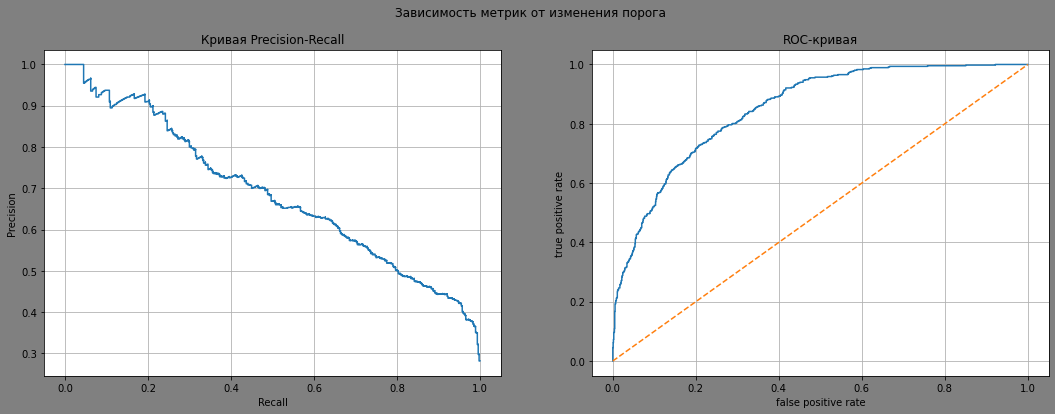

In [76]:
auc_roc_plot(best_model, target_test, prob_test_ones)

### Анализ метрики auc_roc алгоритма XGBClassifier

In [77]:
%%time
xgb = XGBClassifier(random_state=rs, n_jobs=-1)
params = {'n_estimators': [i for i in range(10, 100, 10)],
          'learning_rate': [i for i in np.arange(0.05, 0.12, 0.01)],
          'max_depth': [i for i in range(1, 6, 1)]}

gs_xgb = GridSearchCV(xgb, params, scoring=('f1'), n_jobs=-1, cv=3)
gs_xgb.fit(features_train, target_train)
gs_xgb.best_params_

C:\Users\George\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1min 4s


{'learning_rate': 0.11000000000000001, 'max_depth': 5, 'n_estimators': 90}

In [78]:
model = XGBClassifier(**gs_xgb.best_params_)
cv_search(model, features_train, target_train, features_test)

[11:36:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\George\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[11:36:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Оценю важность признаков и оставлю только самые весомые:

<AxesSubplot:>

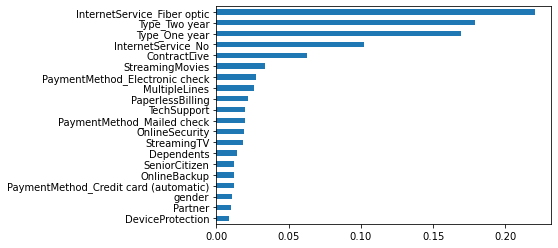

In [79]:
importances = pd.Series(model.feature_importances_, index=features.columns)
importances.sort_values().plot(kind='barh')

In [80]:
xgb_count = 5

In [81]:
features_train_xgb = features_train.drop(columns=importances.sort_values(ascending=False).index[xgb_count:])
features_test_xgb = features_test.drop(columns=importances.sort_values(ascending=False).index[xgb_count:])
features_train_xgb.head()

,ContractLive,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No
1715,-1.240762,-0.518366,-0.553548,1.124928,-0.520426
6648,0.684006,1.929139,-0.553548,-0.888945,1.921502
4949,-0.791200,-0.518366,-0.553548,-0.888945,1.921502
4673,-0.954065,-0.518366,-0.553548,1.124928,-0.520426
3503,-1.282487,-0.518366,-0.553548,-0.888945,-0.520426


In [82]:
%%time
xgb = XGBClassifier(random_state=rs, n_jobs=-1)
params = {'n_estimators': [i for i in range(10, 100, 10)],
          'learning_rate': [i for i in np.arange(0.15, 0.25, 0.01)],
          'max_depth': [i for i in range(1, 6, 1)]}

gs_xgb = GridSearchCV(xgb, params, scoring=('f1'), n_jobs=-1, cv=3)
gs_xgb.fit(features_train_xgb, target_train)
gs_xgb.best_params_

[11:37:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 56.2 s


C:\Users\George\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'learning_rate': 0.24000000000000007, 'max_depth': 5, 'n_estimators': 90}

In [83]:
model = XGBClassifier(**gs_xgb.best_params_)
cv_search(model, features_train_xgb, target_train, features_test_xgb)

C:\Users\George\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[11:37:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Использую технику увеличения и уменьшения баланса классов:

In [84]:
features_upsampled_xgb = features_upsampled.drop(columns=importances.sort_values(ascending=False).index[xgb_count:])
features_downsampled_xgb = features_downsampled.drop(columns=importances.sort_values(ascending=False).index[xgb_count:])
features_upsampled_xgb.head()

,ContractLive,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No
3468,1.339504,-0.518366,-0.553548,1.124928,-0.520426
3984,-1.158656,-0.518366,-0.553548,1.124928,-0.520426
6484,-0.626989,1.929139,-0.553548,-0.888945,-0.520426
4151,0.273479,-0.518366,1.806527,-0.888945,1.921502
6213,1.381230,-0.518366,-0.553548,1.124928,-0.520426


In [85]:
%%time
xgb = XGBClassifier(random_state=rs, n_jobs=-1)
params = {'n_estimators': [i for i in range(10, 200, 10)],
          'learning_rate': [i for i in np.arange(0.1, 0.2, 0.01)],
          'max_depth': [i for i in range(2, 6, 1)]}

gs = GridSearchCV(xgb, params, scoring=('f1'), n_jobs=-1, cv=3)
gs.fit(features_upsampled_xgb, target_upsampled)
gs.best_params_

C:\Users\George\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:41:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 4min 28s


{'learning_rate': 0.18999999999999995, 'max_depth': 5, 'n_estimators': 190}

In [86]:
model = XGBClassifier(**gs.best_params_)
cv_search(model, features_upsampled_xgb, target_upsampled, features_test_xgb)

[11:41:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\George\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[11:41:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:41:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:41:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:41:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [87]:
%%time
xgb = XGBClassifier(random_state=rs, n_jobs=-1)
params = {'n_estimators': [i for i in range(10, 200, 10)],
          'learning_rate': [i for i in np.arange(0.05, 0.15, 0.01)],
          'max_depth': [i for i in range(2, 6, 1)]}

gs = GridSearchCV(xgb, params, scoring=('roc_auc'), n_jobs=-1, cv=3)
gs.fit(features_downsampled_xgb, target_downsampled)
gs.best_params_

C:\Users\George\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2min 8s


{'learning_rate': 0.14, 'max_depth': 4, 'n_estimators': 190}

In [88]:
model = XGBClassifier(**gs.best_params_)
cv_search(model, features_downsampled_xgb, target_downsampled, features_test_xgb)

[11:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\George\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[11:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Использую технику изменения порога баланса классов:

In [89]:
model = XGBClassifier(**gs_xgb.best_params_)
model.fit(features_train_val, target_train_val)
prob_valid = model.predict_proba(features_valid)
prob_valid_ones = prob_valid[:, 1]

f1, auc, accuracy, threshold_xgb = threshold(begin=0, end=1, step=0.01, features=features_valid, 
                                              target=target_valid, prob_ones=prob_valid_ones)

print(f'Валидационная выборка на пороге thresold = {threshold_xgb}:')
print(f'f1 = {f1}')
print(f'accuracy = {accuracy}')
print(f'auc = {auc}')

[11:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\George\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Валидационная выборка на пороге thresold = 0.53:
f1 = 0.6873315363881402
accuracy = 0.8993973859469094
auc = 0.8534428300694883


In [90]:
best_model = XGBClassifier(**gs_xgb.best_params_)
best_model.fit(features_train, target_train)
prob = best_model.predict_proba(features_test)
prob_test_ones = prob[:, 1]
predicted_test = prob_test_ones > threshold_xgb

f1 = f1_score(target_test, predicted_test)
auc = roc_auc_score(target_test, predicted_test)
accuracy = accuracy_score(target_test, predicted_test)

print(f'Тестовая выборка на пороге thresold = {threshold_xgb}:')
print(f'f1 = {f1}')
print(f'accuracy = {accuracy}')
print(f'auc = {auc}')

[11:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\George\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Тестовая выборка на пороге thresold = 0.53:
f1 = 0.7380073800738007
accuracy = 0.878839590443686
auc = 0.803383496683513


C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Наилучшего результата добился при использовании техники увеличения баланса класса. roc_auc=0.8639

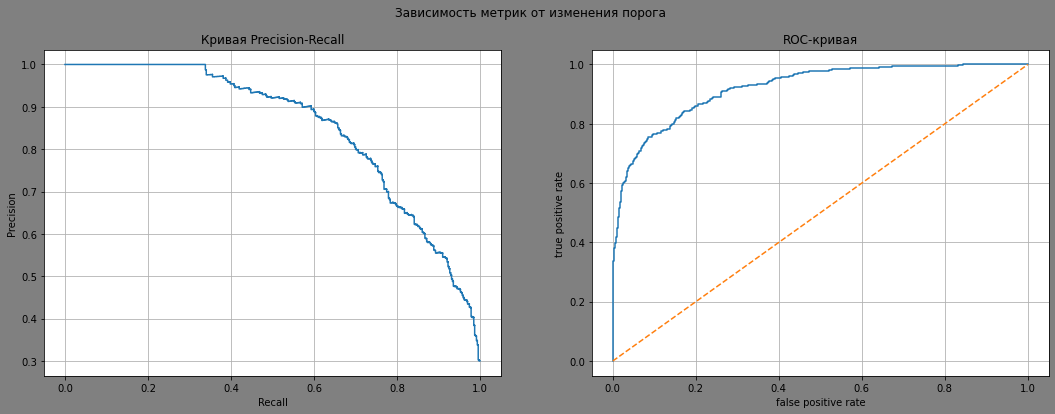

In [91]:
auc_roc_plot(best_model, target_test, prob_test_ones)

predict_plot(target_test, predict_test, 100)

### Анализ метрики auc_roc алгоритма LGBMClassifier

In [92]:
%%time
lgb = LGBMClassifier(random_state=rs, n_jobs=-1)
params = {'n_estimators': [i for i in range(10, 100, 10)],
          'learning_rate': [i for i in np.arange(0.05, 0.2, 0.01)],
          'max_depth': [i for i in range(1, 6, 1)]}

gs_lgb = GridSearchCV(lgb, params, scoring=('roc_auc'), n_jobs=-1, cv=5)
gs_lgb.fit(features_train, target_train)
gs_lgb.best_params_

Wall time: 2min 10s


{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 90}

In [93]:
model = LGBMClassifier(**gs_lgb.best_params_)
cv_search(model, features_train, target_train, features_test)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.773281809290207
f1 на валидационной выборке: 0.6970883827102475
f1 на тестовой выборке: 0.6925880923450791

Разница метрики f1 между train and valid не превышает 9.9%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 1e+01%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.6102783725910065
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.800561797752809
Среднее гармоническое полноты и точности - F1: 0.6925880923450791
Accuracy: 0.8560864618885097
ROC_AUC =  0.7776411227788496


Оценю важнось признаков и возьму только самые весомые:

<AxesSubplot:>

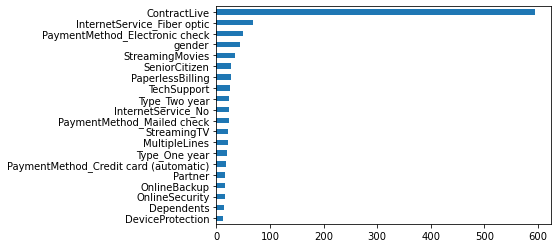

In [94]:
importances = pd.Series(model.feature_importances_, index=features.columns)
importances.sort_values().plot(kind='barh')

In [95]:
lgb_count = 5

In [96]:
features_train_lgb = features_train.drop(columns=importances.sort_values(ascending=False).index[xgb_count:])
features_test_lgb = features_test.drop(columns=importances.sort_values(ascending=False).index[xgb_count:])
features_train_lgb.head()

,ContractLive,StreamingMovies,gender,PaymentMethod_Electronic check,InternetService_Fiber optic
1715,-1.240762,0.802186,1.007613,-0.706805,1.124928
6648,0.684006,0.802186,1.007613,-0.706805,-0.888945
4949,-0.791200,0.802186,-0.992444,1.414817,-0.888945
4673,-0.954065,-1.246593,-0.992444,1.414817,1.124928
3503,-1.282487,0.802186,-0.992444,-0.706805,-0.888945


In [97]:
%%time
lgb = LGBMClassifier(random_state=rs, n_jobs=-1)
params = {'n_estimators': [i for i in range(10, 200, 10)],
          'learning_rate': [i for i in np.arange(0.05, 0.2, 0.01)],
          'max_depth': [i for i in range(1, 6, 1)]}

gs_lgb = GridSearchCV(lgb, params, scoring=('roc_auc'), n_jobs=-1, cv=5)
gs_lgb.fit(features_train_lgb, target_train)
gs_lgb.best_params_

Wall time: 3h 26min 33s


{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 190}

In [98]:
model = LGBMClassifier(**gs_lgb.best_params_)
cv_search(model, features_train_lgb, target_train, features_test_lgb)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.7941193371668851
f1 на валидационной выборке: 0.735127200326216
f1 на тестовой выборке: 0.7741176470588235

Разница метрики f1 между train and valid не превышает 7.4%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 2.5%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.7044967880085653
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.8590078328981723
Среднее гармоническое полноты и точности - F1: 0.7741176470588235
Accuracy: 0.8907849829351536
ROC_AUC =  0.8313343738648559


Использую техники увеличения и уменьшения баланса классов:

In [99]:
features_upsampled_lgb = features_upsampled.drop(columns=importances.sort_values(ascending=False).index[xgb_count:])
features_downsampled_lgb = features_downsampled.drop(columns=importances.sort_values(ascending=False).index[xgb_count:])
features_upsampled_lgb.head()

,ContractLive,StreamingMovies,gender,PaymentMethod_Electronic check,InternetService_Fiber optic
3468,1.339504,0.802186,-0.992444,1.414817,1.124928
3984,-1.158656,-1.246593,1.007613,1.414817,1.124928
6484,-0.626989,-1.246593,-0.992444,1.414817,-0.888945
4151,0.273479,0.802186,-0.992444,-0.706805,-0.888945
6213,1.381230,-1.246593,-0.992444,-0.706805,1.124928


In [100]:
%%time
lgb = LGBMClassifier(random_state=rs, n_jobs=-1)
params = {'n_estimators': [i for i in range(10, 200, 10)],
          'learning_rate': [i for i in np.arange(0.05, 0.2, 0.01)],
          'max_depth': [i for i in range(2, 6, 1)]}

gs = GridSearchCV(lgb, params, scoring=('f1'), n_jobs=-1, cv=3)
gs.fit(features_upsampled_lgb, target_upsampled)
gs.best_params_

Wall time: 1min 48s


{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 180}

In [101]:
model = LGBMClassifier(**gs.best_params_)
cv_search(model, features_upsampled_lgb, target_upsampled, features_test_lgb)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.8700932834431614
f1 на валидационной выборке: 0.8435809974248155
f1 на тестовой выборке: 0.762303664921466

Разница метрики f1 между train and valid не превышает 3.0%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 1.2e+01%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.7794432548179872
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.7459016393442623
Среднее гармоническое полноты и точности - F1: 0.762303664921466
Accuracy: 0.8708759954493743
ROC_AUC =  0.8416968404221616


In [102]:
%%time
lgb = LGBMClassifier(random_state=rs, n_jobs=-1)
params = {'n_estimators': [i for i in range(10, 200, 10)],
          'learning_rate': [i for i in np.arange(0.05, 0.2, 0.01)],
          'max_depth': [i for i in range(2, 6, 1)]}

gs = GridSearchCV(lgb, params, scoring=('f1'), n_jobs=-1, cv=3)
gs.fit(features_downsampled_lgb, target_downsampled)
gs.best_params_

Wall time: 1min 25s


{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 190}

In [103]:
model = LGBMClassifier(**gs.best_params_)
cv_search(model, features_downsampled_lgb, target_downsampled, features_test_lgb)

Перекресная проверка (кросс-валидация):
f1 на обучающей выборке: 0.8854909452062423
f1 на валидационной выборке: 0.8371280394750258
f1 на тестовой выборке: 0.7011393514461

Разница метрики f1 между train and valid не превышает 5.5%. Переобучения нет, если разница <10%
Разница метрики f1 между train and test не превышает 2.1e+01%.

Тестовая выборка:
Доля положительных предсказаний от всех правильных предсказаний - Recall:  0.8565310492505354
Доля положительных предсказаний от всех положительных предсказаний - Precision:  0.5934718100890207
Среднее гармоническое полноты и точности - F1: 0.7011393514461
Accuracy: 0.8060295790671217
ROC_AUC =  0.8221462372511392


Использую технику изменения порога баланса классов:

In [104]:
model = LGBMClassifier(**gs_lgb.best_params_)
model.fit(features_train_val, target_train_val)
prob_valid = model.predict_proba(features_valid)
prob_valid_ones = prob_valid[:, 1]

f1, auc, accuracy, threshold_lgb = threshold(begin=0, end=1, step=0.01, features=features_valid, 
                                              target=target_valid, prob_ones=prob_valid_ones)

print(f'Валидационная выборка на пороге thresold = {threshold_lgb}:')
print(f'f1 = {f1}')
print(f'accuracy = {accuracy}')
print(f'auc = {auc}')

Валидационная выборка на пороге thresold = 0.48:
f1 = 0.7090216010165185
accuracy = 0.9052293326683047
auc = 0.8553379658875553


In [105]:
best_model = LGBMClassifier(**gs_lgb.best_params_)
best_model.fit(features_train, target_train)
prob = best_model.predict_proba(features_test)
prob_test_ones = prob[:, 1]
predicted_test = prob_test_ones > threshold_lgb

f1 = f1_score(target_test, predicted_test)
auc = roc_auc_score(target_test, predicted_test)
accuracy = accuracy_score(target_test, predicted_test)

print(f'Тестовая выборка на пороге thresold = {threshold_lgb}:')
print(f'f1 = {f1}')
print(f'accuracy = {accuracy}')
print(f'auc = {auc}')

Тестовая выборка на пороге thresold = 0.48:
f1 = 0.7654609101516918
accuracy = 0.8856655290102389
auc = 0.8271653366993036


Наилучший результат я получил при использовании техники уменьшения баланса классов. roc_auc = 0.855

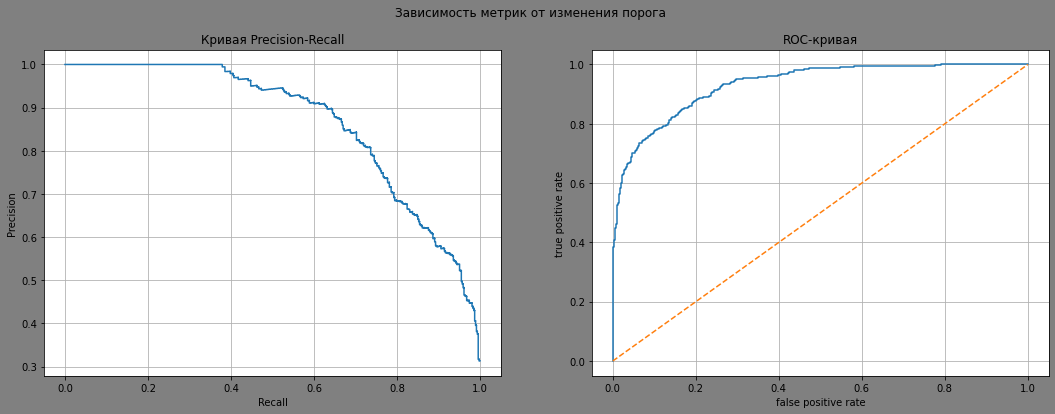

In [106]:
auc_roc_plot(best_model, target_test, prob_test_ones)

predict_plot(target_test, predict_test, 100)

## Итого

Наилучшую модель я получил при использовании алгоритма XGBoostClassifier() и техники увеличения баланса классов. Roc_auc = 0.864